In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [0]:
# Path to file filtered_data.csv
DATA_PATH="/content/filtered_data.csv"
data = pd.read_csv(DATA_PATH) ;
data.head(10)

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [0]:
new_data =data.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')

In [0]:
new_data.shape

(19213, 4444)

### Performing Heirarachical Clustering to evaluate the best number of cluster possible based on above grouped data (Below tab code take a considerable time to compute.)

In [0]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    
    dend = dendrogram(linkage_matrix, **kwargs)
    return dend
X = np.array(new_data)
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)


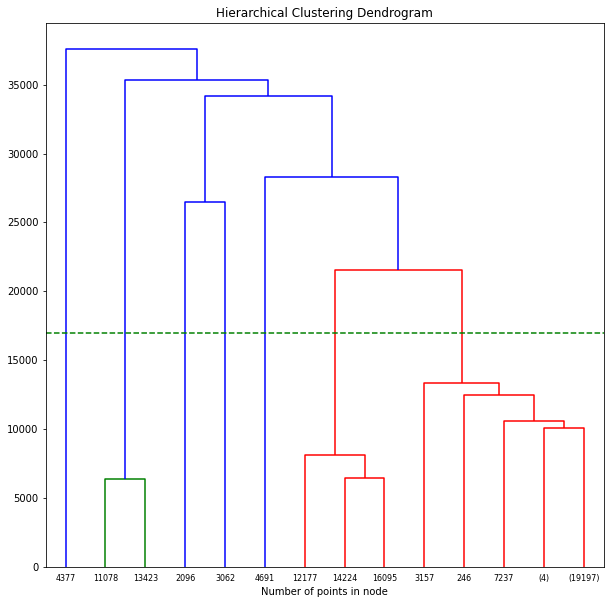

In [0]:
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top levels of the dendrogram
dend = plot_dendrogram(model, truncate_mode='level',p=8,leaf_font_size=8, get_leaves=True) #p is the number of levels
plt.xlabel("Number of points in node")
plt.axhline(y=17000, color='g', linestyle='--')
plt.show()

For only 19000 rows , Heirarchical clustering takes a much longer time to fit the data. 
In the later part of the notebook we will be applying clustering on more than 4 lakh rows of data using two phase clustering.


Here we can clearly visualize the above dendogram that the number of cluster should be 7 for this dataset. (The line is cutting 7 vertical lines ).


In [0]:
# Dropping the features likie Invoice, StockCode and InvoiceDate
exp_data=data.drop(columns=['Invoice','StockCode','InvoiceDate'],axis=1)

In [0]:
exp_data

,Unnamed: 0,Description,Quantity,Price,Customer ID,Country
0,0,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom
1,1,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2,2,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
3,3,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom
4,4,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...
400911,525456,FELTCRAFT DOLL ROSIE,2,2.95,17530.0,United Kingdom
400912,525457,FELTCRAFT PRINCESS LOLA DOLL,1,3.75,17530.0,United Kingdom
400913,525458,FELTCRAFT PRINCESS OLIVIA DOLL,1,3.75,17530.0,United Kingdom
400914,525459,PINK FLORAL FELTCRAFT SHOULDER BAG,2,3.75,17530.0,United Kingdom


In [0]:
# Encoding the Categorical variable like product description and Country
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

exp_data['Description'] = labelencoder.fit_transform(exp_data['Description'] )
exp_data['Description'] 

exp_data['Country'] = labelencoder.fit_transform(exp_data['Country'] )
exp_data['Country'] 

0         34
1         34
2         34
3         34
4         34
          ..
400911    34
400912    34
400913    34
400914    34
400915    34
Name: Country, Length: 400916, dtype: int64

In [0]:
#Dropping null values
exp_data.dropna(inplace=True)

## Two Step Clustering


We will apply clustering algorithm on each product transaction to classify them into 7 clusters. As we have seen above Heirarchical clustering algorithm will not able to cluster this huge amount of  data. So we first form the preclusters using K-means and then apply Heirarchical Clustering.

#### First Step - Generating 100 preclusters using k-means algorithm.



In [0]:
# Generating 100 pre-clusters using K-means.
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=100, n_init=10,
 random_state=1)
clustering.fit(exp_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [0]:
# Kx = clustering.cluster_centers_
K_means_centres=clustering.cluster_centers_
Kx_mapping = {case:cluster for case,
 cluster in enumerate(clustering.labels_)}

In [0]:
K_means_centres[:10]

array([[2.09009036e+05, 2.38024989e+03, 1.60856118e+01, 3.22952488e+00,
        1.52622844e+04, 3.17978485e+01],
       [3.98607333e+05, 2.30537469e+03, 1.07536200e+01, 3.10933393e+00,
        1.55105471e+04, 3.26631767e+01],
       [6.64043104e+04, 2.33567031e+03, 3.01815346e+01, 3.53271990e+00,
        1.50657193e+04, 3.11122895e+01],
       [4.82517025e+05, 2.31453239e+03, 1.07564540e+01, 3.07745251e+00,
        1.56010202e+04, 3.21534340e+01],
       [3.07980467e+05, 2.38802829e+03, 1.88188302e+01, 2.88431526e+00,
        1.53832411e+04, 3.23975273e+01],
       [1.39442979e+05, 2.37355921e+03, 1.15898814e+01, 2.99826058e+00,
        1.53795977e+04, 3.21484218e+01],
       [2.21404913e+04, 2.36082576e+03, 1.16892316e+01, 3.64768352e+00,
        1.52974267e+04, 3.31328192e+01],
       [2.51939945e+05, 2.37337917e+03, 1.48615206e+01, 3.43255237e+00,
        1.50749438e+04, 3.16920093e+01],
       [3.52082479e+05, 2.32582648e+03, 1.19042882e+01, 2.73048851e+00,
        1.55338506e+04, 

#### Second step - Implementing Heirarchical Clustering on the pre-clusters

In [0]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

X = np.array(K_means_centres)

model=AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
model.fit(X)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=7)

In [0]:
#Predicting the clusters of 100 pre-clusters
model.fit_predict(X)

array([4, 2, 0, 7, 1, 6, 5, 3, 7, 1, 4, 6, 0, 0, 5, 6, 1, 1, 0, 2, 7, 6,
       3, 6, 5, 2, 3, 5, 5, 7, 1, 0, 4, 2, 3, 4, 0, 7, 6, 0, 7, 2, 0, 3,
       0, 7, 4, 4, 5, 2, 0, 6, 2, 2, 5, 0, 1, 3, 7, 1, 4, 0, 7, 2, 3, 1,
       6, 5, 6, 1, 2, 4, 0, 2, 0, 2, 1, 0, 7, 7, 0, 0, 6, 2, 5, 3, 3, 1,
       5, 1, 4, 5, 4, 2, 3, 0, 0, 0, 2, 2])

In [0]:
#Assining Clusteters to the orignal numbers
H_mapping = {case:cluster for case,
 cluster in enumerate(model.fit(X)
.labels_)}
final_mapping = {case:H_mapping[Kx_mapping[case]]
 for case in Kx_mapping}

In [0]:
result=pd.DataFrame(final_mapping,index=[0])


In [0]:
result=result.T

In [0]:
result.columns=['Cluster']

In [0]:
#Concating initail data and clusters
combined_data = pd.concat([exp_data, result], axis=1)

In [0]:
combined_data

,Unnamed: 0,Description,Quantity,Price,Customer ID,Country,Cluster
0,0,51,12,6.95,13085.0,34,6
1,1,2805,12,6.75,13085.0,34,6
2,2,27,12,6.75,13085.0,34,6
3,3,3118,48,2.10,13085.0,34,6
4,4,3933,24,1.25,13085.0,34,6
...,...,...,...,...,...,...,...
400911,525456,1445,2,2.95,17530.0,34,2
400912,525457,1454,1,3.75,17530.0,34,2
400913,525458,1455,1,3.75,17530.0,34,2
400914,525459,2845,2,3.75,17530.0,34,2


In [0]:
combined_data.drop(columns=['Unnamed: 0'],inplace=True)
combined_data.drop(columns=['Customer ID'],inplace=True)

In [0]:
combined_data

,Description,Quantity,Price,Country,Cluster
0,51,12,6.95,34,6
1,2805,12,6.75,34,6
2,27,12,6.75,34,6
3,3118,48,2.10,34,6
4,3933,24,1.25,34,6
...,...,...,...,...,...
400911,1445,2,2.95,34,2
400912,1454,1,3.75,34,2
400913,1455,1,3.75,34,2
400914,2845,2,3.75,34,2


In [0]:
#Applying PCA to visualize cluster analysis
from sklearn.preprocessing import StandardScaler

x = combined_data.drop(columns=['Cluster'])
y = combined_data['Cluster'].values
x = StandardScaler().fit_transform(x)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [0]:
finalDf = pd.concat([principalDf, combined_data[['Cluster']]], axis = 1)

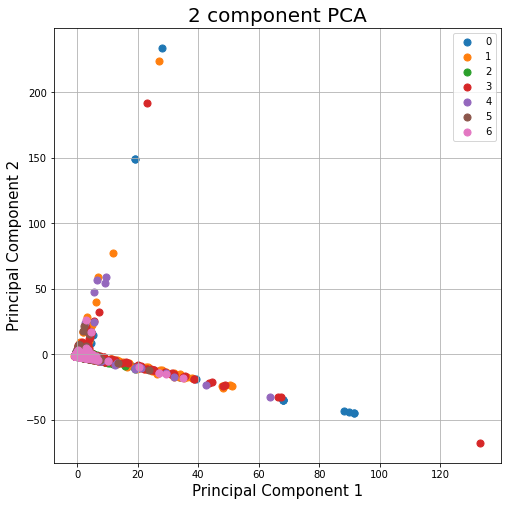

In [0]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2,3,4,5,6]

for target in zip(targets):
    indicesToKeep = finalDf['Cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               
               , s = 50)
ax.legend(targets)
ax.grid()

Clusters are not clearly isolated as we were expecting from the Two step clustering . There is many possible directions that can be further explored. Such as , encoding of categorical variables based on co-occurance can be done rather than simply Label encoding the variables. 
The main advantage of two steps clustering analysis is it can handle huge amount of data. Cluster centre may be slightly distorted with the two phase, but it is efficent for large datasets.
When we tried, above data of 4 lakh rows in Hierarchical clustering ,kernal  crashed and we were unable to get any  result.